# ECSE 551 MP3 G17

## Define constants, import libraries, setup device

In [ ]:
# Connect to Google Drive to load the dataset
# Make sure to run this cell first!
from google.colab import drive
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold

drive.mount('/content/drive')
# Define Global Constants
# Please modify the path according to the actual situation
TRAIN_PKL_FILE = '/content/drive/MyDrive/Colab Notebooks/data/551Project3/Train.pkl'
TRAIN_LABEL_FILE = '/content/drive/MyDrive/Colab Notebooks/data/551Project3/Train_labels.csv'
TEST_PKL_FILE = '/content/drive/MyDrive/Colab Notebooks/data/551Project3/Test.pkl'
SUBMISSION_FILE = '/content/drive/MyDrive/Colab Notebooks/data/551Project3/Submission.csv'

# Set up the device
# For Google Colab, switch the GPU runtime to gain best performance
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


## Scripts Starts Here

### Load and Read the PKL Test Dataset

<class 'numpy.ndarray'>
Data dimensions: (60000, 1, 28, 28)


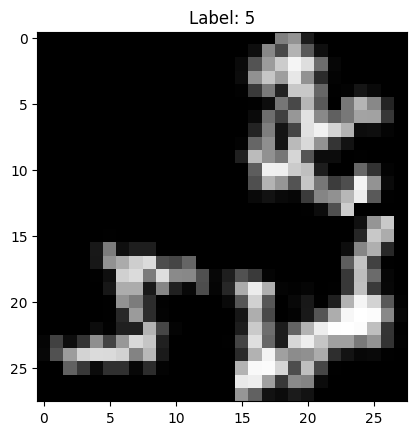

In [ ]:
# File paths
pkl_file_path = TRAIN_PKL_FILE
csv_file_path = TRAIN_LABEL_FILE

# Open and load the pkl file
with open(pkl_file_path, 'rb') as file:
    data = pickle.load(file)

# Load the CSV file
labels_df = pd.read_csv(csv_file_path)

# Create a dictionary to map IDs to classes
labels_dict = dict(zip(labels_df['id'], labels_df['class']))

# Check data structure
print(type(data))  # View data type

# If the data is an image array
if isinstance(data, np.ndarray):
    print("Data dimensions:", data.shape)  # Check data dimensions

    # Assign labels from the CSV file
    image_labels = [labels_dict.get(i+1, 'Unknown') for i in range(len(data))]

    # Display the first image (assuming it is a grayscale image)
    plt.imshow(data[0].squeeze(), cmap='gray')
    plt.title(f"Label: {image_labels[0]}")
    plt.show()

## CNN

### Prepare the data

In [ ]:
# 加载训练数据和标签
with open(TRAIN_PKL_FILE, 'rb') as file:
    train_data = pickle.load(file)

labels_df = pd.read_csv(TRAIN_LABEL_FILE)
labels_dict = dict(zip(labels_df['id'], labels_df['class']))
train_labels = [labels_dict.get(i + 1, 'Unknown') for i in range(len(train_data))]

# 定义自定义数据集
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return image, label

# 创建数据集和数据加载器
dataset = CustomDataset(train_data, train_labels)

### Define the CNN Model

In [ ]:
# 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 假设有 10 个类别

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 移除了多余的 unsqueeze
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### X-Validation Training and Testing

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}")
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = SimpleCNN().to(DEVICE)  # 将模型移动到设备上
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    for epoch in range(10):  # 根据需要调整 epoch 数量
        model.train()
        for images, labels in train_loader:
            images = images.to(DEVICE)  # 移动数据到设备上
            labels = labels.to(DEVICE)  # 移动标签到设备上
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 在验证集上评估模型
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)  # 移动数据到设备上
                labels = labels.to(DEVICE)  # 移动标签到设备上
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy:.2f}%")

Fold 1
Epoch 1, Validation Accuracy: 84.83%
Epoch 2, Validation Accuracy: 88.91%
Epoch 3, Validation Accuracy: 89.69%
Epoch 4, Validation Accuracy: 91.21%
Epoch 5, Validation Accuracy: 90.81%
Epoch 6, Validation Accuracy: 91.18%
Epoch 7, Validation Accuracy: 91.28%
Epoch 8, Validation Accuracy: 91.43%
Epoch 9, Validation Accuracy: 92.26%
Epoch 10, Validation Accuracy: 91.52%
Fold 2
Epoch 1, Validation Accuracy: 83.64%
Epoch 2, Validation Accuracy: 88.07%
Epoch 3, Validation Accuracy: 89.56%
Epoch 4, Validation Accuracy: 90.28%
Epoch 5, Validation Accuracy: 90.77%
Epoch 6, Validation Accuracy: 91.11%
Epoch 7, Validation Accuracy: 90.61%
Epoch 8, Validation Accuracy: 91.57%
Epoch 9, Validation Accuracy: 91.57%
Epoch 10, Validation Accuracy: 92.21%
Fold 3
Epoch 1, Validation Accuracy: 83.72%
Epoch 2, Validation Accuracy: 89.47%
Epoch 3, Validation Accuracy: 89.38%
Epoch 4, Validation Accuracy: 89.01%
Epoch 5, Validation Accuracy: 90.66%
Epoch 6, Validation Accuracy: 91.92%
Epoch 7, Valida

### Run Prediction on Test Dataset

In [ ]:
# 加载测试数据
with open(TEST_PKL_FILE, 'rb') as file:
    test_data = pickle.load(file)

test_dataset = torch.tensor(test_data, dtype=torch.float32)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 在测试集上进行推理
model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(DEVICE)  # 移动测试数据到设备上
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# 保存预测结果到 CSV 文件
submission_df = pd.DataFrame({
    'id': np.arange(1, len(predictions) + 1),
    'class': predictions
})
submission_df.to_csv(SUBMISSION_FILE, index=False)
print(f"Predictions results have been saved to: {SUBMISSION_FILE}")

Predictions results have been saved to: /content/drive/MyDrive/Colab Notebooks/data/551Project3/Submission.csv
